# SpaRSA (Sparse Reconstruction by Separable Approximation)

## Import necessary packages

In [49]:
import numpy as np
from numpy import linalg as LA
import sys
import matplotlib.pyplot as plt

## The main problem
We want to solve the following problem
$$ \min_{\mathbf{x}} \phi(\mathbf{x}) := f(\mathbf{x}) + \tau c(\mathbf{x}) $$
where we choose 
$$ f(\mathbf{x}) = \frac{1}{2} || \mathbf{A}\mathbf{x} - \mathbf{y}||_2^2 $$
and $c(\mathbf{x})$ to be either the $\ell_1$- or $\ell_0$-norm.

In [19]:
def f(A, x, y):
    residual = A @ x - y
    return np.dot(residual, residual) / 2

def gradient(A, x, y):
    return A.T @ (A @ x - y)

def phi(A, x, y, tau, norm=1):
    return f(A, x, y) + tau * LA.norm(x, norm)

## Solving the sub-problem
Under each iteration, we need to solve a sub-problem. There are two closed form when we choose $c(\mathbf{z})$ to be either the $\ell_1$- or the $\ell_0$-norm.

Define the soft-threshold function, which is used when $c(\mathbf{z})$ is the $\ell_1$-norm.
$$ \text{soft}(u, a) = \text{sgn}(u) \max \{0, |u|-a \} $$

Define the hard-threshold function, which is used when $c(\mathbf{z})$ is the $\ell_0$-norm.
$$ \text{hard}(u, a) = u 1_{|u|>a} $$

When $c(\mathbf{z})$ is the $\ell_1$-norm, 
$$ \mathbf{x}^{k+1} = \text{soft} (\mathbf{u}^k, \frac{\tau}{\alpha_k}) $$ 

When $c(\mathbf{z})$ is the $\ell_0$-norm, 
$$ \mathbf{x}^{k+1} = \text{hard} (\mathbf{u}^k, \sqrt{\frac{2\tau}{\alpha_k}}) $$

The vector $\mathbf{u}$ is defined as
$$ \mathbf{u}^k = \mathbf{x}^k - \nabla f(\mathbf{x}^k) / \alpha_k $$

In [54]:
def soft(u, a):
    # u is a vector, a is a scalar
    # element-wise operations
    return np.sign(u) * np.maximum(np.abs(u) - a, 0)

def hard(u, a):
    # u is a vector, a is a scalar
    # element-wise operations
    return u * (np.abs(u) > a)

def solve_sub_prob(u, tau, alpha, norm=1):
    # u: vector
    # tau, alpha: scalar
    # norm: 1 or 0 (either l-1 or l-0 norm)
    # assume we do not use any other norms
    if norm == 1:
        return soft(u, tau / alpha)
    return hard(u, np.sqrt(2 * tau / alpha))

## The Barzilai-Borwein Method
The Barzilai-Borwein method is used to choose $\alpha_k$ such that $\alpha_k \mathbf{I}$ mimics the Hessian $\nabla^2 f(\mathbf{x})$ over the most recent step. We have 
$$ \alpha_k = \frac{(\mathbf{s}^k)^T \mathbf{r}^k}{(\mathbf{s}^k)^T \mathbf{s}^k} $$
where $\mathbf{s}^k = \mathbf{x}^k - \mathbf{x}^{k-1}$ and $\mathbf{r}^k = \nabla f(\mathbf{x}^k) - \nabla f(\mathbf{x}^{k-1})$.

With $ f(\mathbf{x}) = \frac{1}{2} || \mathbf{A}\mathbf{x} - \mathbf{y}||_2^2 $, we further simply that
$$ \alpha_k = \frac{||\mathbf{A} \mathbf{s}^k||_2^2}{||\mathbf{s}^k||_2^2} $$

In [56]:
def barzilai_borwein(A, x, prev_x):
    alpha_min = 1e-10 # constant alpha min
    alpha_max = 1e10 # constant alpha max
    # A: given matrix
    # x: x_k
    # prev_x: x_(k-1)
    s = x - prev_x
    # add fl. pt. correction
    alpha = np.dot(A @ s, A @ s) / (sys.float_info.min + np.dot(s, s))
    alpha = min(alpha_max, max(alpha_min, alpha))
    return alpha

## The main algorithm
We put everything together.

In [52]:
def spaRSA(A, y, tau, norm=1):
    eta = 1.5 # factor, eta > 1
    k = 0 # iter counter
    x = np.zeros(A.shape[1]) # init guess of x
    alpha = 1.0 # init alpha
    tol = 1e-4
    
    while True:
        # save current value
        prev_x = x
        prev_phi = phi(A, prev_x, y, tau, norm)
        # find the next x
        while True:
            u = prev_x - gradient(A, prev_x, y) / alpha
            x = solve_sub_prob(u, tau, alpha, norm) # update x_k
            alpha *= eta # update alpha_k
            curr_phi = phi(A, x, y, tau, norm)
            if curr_phi < prev_phi:
                break # the acceptance criterion is satisfied

        k += 1 # update counter
        alpha = barzilai_borwein(A, x, prev_x) # choose the next alpha
        if np.abs(curr_phi - prev_phi) / prev_phi < tol:
            break # stop criterion: no more relative decrease
    # end of outer loop
    yhat = A @ x
    return x, yhat

## Test cases (L-1 norm)
Choose some matrix $ \mathbf{A} $, vector $ \mathbf{y} $, and scalar $ \tau $.

Text(0.5, 1.0, 'inputs')

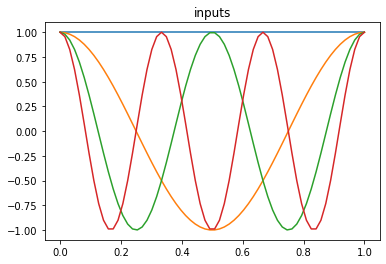

In [50]:
# generate a grid
npts = 64
domain = np.linspace(0, 1, npts)

# generate a dictionary and manufactured solution
A = np.array([np.cos(2 * np.pi * m * domain) for m in range(4)]).T
soltncoef = [0., 1., 0., .5]
y = np.dot(A, soltncoef)

tau = 0.2 * np.max(np.abs(gradient(A, np.zeros(A.shape[1]), y)))

plt.plot(domain, A)
plt.title('inputs')

Text(0.5, 1.0, 'Response')

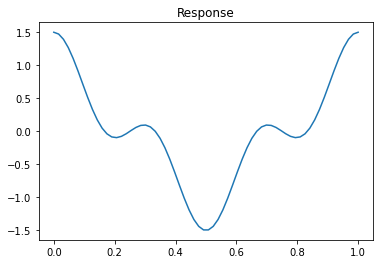

In [51]:
plt.plot(domain, y)
plt.title('Response')

In [57]:
# reconstruct
x, yhat = spaRSA(A, y, tau)

Text(0.5, 1.0, 'Predicted and true responses')

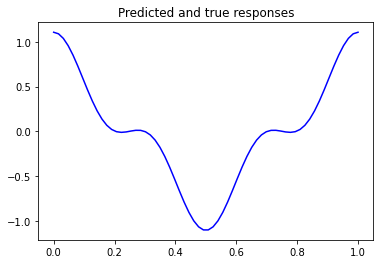

In [58]:
plt.plot(domain, yhat,'b')
plt.title('Predicted and true responses')